<a href="https://colab.research.google.com/github/InhyeokYoo/Pytorch-study/blob/master/8_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

1. Transfer Learning  
2. Multi-task Learning
3. One-shot Learning
3. Style transfer



# 1. Transfer Learning (cs231n)
충분한 크기의 data set을 갖는 것은 상대적으로 드물기 때문에 전체 ConvNet을 처음부터 학습(train from scratch)시키는 경우는 거의 없습니다. 대신, 매우 큰 data set을 통해 ConvNet을 pre-training한 다음에, 새로운 작업에 적용시키는 Transfer Learning을 주로 사용합니다.  
Transfer learning과 domain adaptation은 한 환경에서 (i.e. distribution $P_1$) 배운 것을 다른 환경에서의 (i.e. distribution $P_2$) generalization을 향상시키는 것을 말합니다. 일반적으로, transfer learning, multi-task learning, domain adaptation은 representation learning을 통해 달성할 수 있습니다.
이에는 다음과 같은 3가지 시나리오가 있습니다.  

- **ConvNet as fixed feature extractor**: ImageNet에서 미리 구성된 ConvNet을 사용하고, 마지막으로 fully connected layer를 제거한 다음에 나머지 부분을 새 data set의 fixed feature extractor로 사용합니다. 이미지에서 계산된 feature를 CNN code라고 합니다. 그리고 추출된 code를 사용해서 linear classifier를 학습시킵니다.
- **Fine-tuning the ConvNet**: 새 data set의 ConvNet 상단에서 classifier를 교체하고, re-training하는 것 뿐만 아니라 backpropagation을 계속함으로써 pre-defined networks의 weights을 fine-tuning 하는 방법입니다. ConvNet의 모든 layer를 fine-tuning하거나 이전 layer 중 일부 weights을 고정하고 networks의 일부 상위 layer만 fine-tuning할 수도 있습니다. 이는 모든 layers를 fine-tuning하는 경우, overfitting문제가 발생할 수도 있기 때문입니다.
- **Pretrained models**: ConvNet은 ImageNet의 여러 GPU로 training 시키는 데 2~3주가 걸리므로 networks를 fine-tuning 할 수 있도록 model의 check point를 공개하는 것이 일반적입니다.

## When and how to fine-tune? (CS231n)
새로운 data set에서 수행해야하는 Transfer Learning의 유형을 어떻게 결정할까요? 이를 결정하기 위해서는 몇 가지 요인을 살펴봐야 하지만, 가장 중요한 두 가지 요소는 새로운 data set의 크기와 원본 data set와의 유사성이 있습니다.(예 : ImageNet의 경우 일반적인 클래스와는 유사성을 가지지만, 현미경 이미지와는 매우 다름.). ConvNet features는 초기 레이어에서는 보다 일반적이며, 후반부 레이어에서는 원래의 data set에 보다 관련되어 있다는 점을 주의합니다. 여기 일반적으로 사용하는 4 가지 주요 시나리오가 있습니다.
1. **새로운 data set이 작고 원본 data set과 유사한 경우**  
data가 작기 때문에 ConvNet을 **과도하게 fine-tuning하는 것은 좋지 않습니다.** New data가 original data와 유사하기 때문에 ConvNet의 상위 수준 기능이 이 new data set과 관련이 있다고 기대할 수 있습니다. 따라서, **마지막 linear classifier를 학습시키는 것이 좋습니다.**  

2. **새 데이터 세트가 크고, 원본 데이터 세트와 유사할 경우**:  
더 많은 data를 보유하고 있기 때문에, **전체 network를 fine-tuning** 해도 괜찮습니다.

3. **새 데이터 세트가 작고, 원본 데이터 세트와 매우 다른 경우**  
data가 작기 때문에 **linear classifier만 학습시키는 것이 좋을 것입니다.** 그러나 data의 set이 매우 다르므로 더 많은 data set 관련 기능을 포함하는 거의 마지막부분 (the top of the network)만 학습하는 것은 좋지 않습니다. *(예. CNN의 초기단계와 같은 feature extraction, represent learning 하는 곳)*. 이 경우에는 네트워크 초기 부분 어딘가 activation 이후에 특정 레이어를 학습시키는게 좋습니다.

4. **새 데이터 세트가 크고 원본 데이터 세트와 매우 다른 경우**  
데이터가 많기 때문에 아예 새로운 ConvNet을 만들수도 있지만, **실적적으로 transfer learning이 여전히 유용합니다**. 전체 네트워크에 대해서 fine-tune을 해도 됩니다.

## Practical advice
다음은 transfer learning을 시도할 때 염두해야 될 부분입니다.
- **Constraints from pre-trained models**: pre-trained networks를 사용하는 경우 new data set에 사용할 수 있는 architecture 측면에서 약간 제한 될 수 있습니다. (For example, you can’t arbitrarily take out Conv layers from the pretrained network.) 그러나 명확한 이 점도 있습니다. Parameter sharing이란 특성 덕분에, **다른 size의 image에 대해서도 pre-trained 모델을 사용할 수 있습니다.** *(Conv/Pool layer에서 channel만 중요할 뿐, size는 중요하지 않음을 상기. 단 stride는 맞아야 함.)* Fully connected layer에서도 이는 여전히 유효한데, FC layer는 Conv layer로 변환할 수 있기 때문입니다. 예를 들면 AlexNet에서 마지막에 FC로 들어가기 전 사이즈는 [6x6x512]인데, 이는 6x6을 갖는 receptive field에 zero-padding을 적용한 Conv layer와 같습니다.
- **Learning rates**: 새로운 데이터에 대해 class score를 산출하고 있는 linear classifier를 randomly initialized weight를 훈련하는 것에 비해, fine-tunning 중인 ConvNet의 weight에 더 작은 learning rate를 적용해야 합니다 이는 ConvNet의 weights가 상대적으로 좋기 때문에 빠르게, 많이 왜곡될 가능성이 있기 때문입니다. (이는 특히나 ConvNet 위에 randomly initialized FC layer가 train 되는 경우가 그렇습니다)

## 책 코드

### 1. Settings

In [0]:
!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs
  
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg -P images/cats

rm: cannot remove 'images': No such file or directory
--2019-12-13 09:01:06--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.130.166, 151.101.66.166, 151.101.2.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.130.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.004s  

2019-12-13 09:01:06 (7.80 MB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’ saved [32099/32099]

--2019-12-13 09:01:09--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.77.122
Connecting to www.rspcansw.org.au (www.rspcansw.org.au)|101.0.77.122|:443... connected.
HTTP request sent, awaitin

<center> <img src="https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg" width="400" height="300">

<img src="https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg" width="400" height="300">

<img src="https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg" width="400" height="300">

<img src="https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700" width="400" height="300">

 불러온 그림들 </center>

In [0]:
# Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [0]:
# Hyper parameters

batch_size = 2
learning_rate = 0.001
num_epoch = 10
num_category = 2

In [0]:
# Folder 내 이미지를 가져와 load함.

img_dir = "./images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            ]))

print(img_data.classes)
print(img_data.class_to_idx)
print(img_data.imgs)

['cats', 'dogs']
{'cats': 0, 'dogs': 1}
[('./images/cats/A-gray-cat-crying-looking-upset.jpg', 0), ('./images/cats/c1.jpg', 0), ('./images/dogs/50_a-feature_dogs-and-puppies_mobile.jpg', 1), ('./images/dogs/ol9ceoqxidudap8owlwn.jpg', 1)]


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:704: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [0]:
# 데이터 개수좀 보자

len(img_data) 

4

In [0]:
# Data Loader

train_loader = DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2,drop_last=True)

for img,label in train_loader:
    print(img.size()) # class x input
    print(label)

torch.Size([2, 3, 224, 224])
tensor([1, 0])
torch.Size([2, 3, 224, 224])
tensor([0, 1])


#### Recall: Residual Network의 구조

<center> <img src="https://t1.daumcdn.net/cfile/tistory/99167C335C47F0E315" width="600" height="300">

 ResNet 구조 </center>

In [0]:
# ResNet50 불러오자.
resnet = models.resnet50(pretrained=True)

#### modules() vs. children()

In [0]:
# children() -> immediate children modules
# children()은 pretrained_model을 하나의 요소로써 반환하지 않는다.
# 또한, nested Sequential()에는 접근할 수 없다.

for name, module in resnet.named_children():
    print(name)
    print(module)
    print('='*100)

conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu
ReLU(inplace=True)
maxpool
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05

In [0]:
# modules() -> recursively iterate 할 수 있음.
# return pretrained_model as one of the elements.
# 즉, 첫 번째 구조 -> 안에 있는 Sequential이 있다면, -> 여기서 탐색 -> 반복...
# E.g. nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Sequential(nn.Sigmoid(), nn.ReLU()))
# output:
# nn.Linear, nn.ReLU, nn.Sequential(nn.Sequential(nn.Sigmoid(), nn.ReLU())) -> 전체 모델 반환
# Linear (2 -> 2), ReLU (), Sequential ((0): Sigmoid () (1): ReLU ()) -> 1번째 층의 구조 반환
# sigmoid(), ReLU() -> 1번째 층에 Sequential이 있으므로, 이 안을 탐색.

for m in resnet.modules():
    print(m)
    print('='*100)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Model

In [0]:
# 커스텀 레즈넷을 새로 정의하되 layer0는 이미 학습된 모델의 파라미터를 가져오고
# layer1는 새롭게 만들어서 이 부분을 학습합니다.

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:-1]) # .modules() also returns pretrained_model as one of the elements.
        # FC layer
        self.layer1 = nn.Sequential(
            nn.Linear(2048,500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500,num_category),
            nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer0(x)
        out = out.view(batch_size,-1)
        out= self.layer1(out)
        return out

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Resnet().to(device)

# 모델의 layer0의 파라미터들은 학습이 되지 않도록 기울기 계산을 꺼둡니다.
for params in model.layer0.parameters():
    params.require_grad = False
    
# layer1의 파라미터들은 학습되도록 기울기 계산을 켜둡니다.
for params in model.layer1.parameters():
    params.requires_grad = True

cuda:0


In [0]:
# 모델을 한번 확인합니다
for m in model.children():
    print(m)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [0]:
# define loss func & optimizer
# model.parameters() also works because of the cell right above

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate) 

In [0]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)

tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>)


In [0]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for image,label in train_loader:
      x = image.to(device)
      y_= label.to(device)
      
      output = model.forward(x)
      _,output_index = torch.max(output,1)
      
      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Train Data: {}".format(100*correct/total))

Accuracy of Train Data: 100.0


# 2. Multi-task Learning
<center> <img src="https://vanche.github.io/assets/images/mtl/figure1.png" height="300", weight="300">

Multi-task Learning 중 Hard parameter sharing을 갖는 구조
</center>

보통 머신러닝 모델을 트레이닝할때 특정한 metric을 최적화하는데에 집중하곤 합니다. 그래서 우리가 신경쓰는 metric보다 더 도움이 될수 있을지 모르는 정보를 무시하는 경우가 생깁니다. 따라서, 이를 활용하기 위해 **관련있는 task들의 representation을 공유함으로써, 모델을 더 좋게 일반화**할 수 있는데, 이러한 접근방식을 Multi-Task Learning (MTL)이라고 합니다.
MTL은 joint learning, learning to learn, learning with auxiliary tasks와 같은 이름으로도 언급됩니다. 즉, 하나보다 많은 loss fuction을 최적화하고자 할때, 이를 MTL한다고 할 수 있습니다.  

## Why does MTL work?
- **Implicit data augmetation**: MTL은 데이터 샘플 사이즈를 키우는 효과가 있습니다. 어떤 테스크에 대한 representation을 잘 학습하기 위해서는 데이터 의존적인 노이즈를 무시하고, 일반화할 수 있어야 합니다. 다른 테스크는 다른 노이즈패턴을 가지고 있고, 모델이 여러 테스크를 동시에 학습하면 좀더 일반적인 표현을 학습할 수 있을 것입니다.
- **Attention focusing**: 테스크가 noisy하거나 데이터가 제한되었거나 고차원의 문제라면 모델은 어떤 feature가 관련이 있고 어떤 feature가 관련이 없는지 구분하기 어렵습니다. MTL은 다른테스크들에도 중요한 feature에 attention하게 함으로써 feature의 관련성/무관성을 구분할 추가적인 증거를 제시합니다.
- **Eavesdropping**: 어떤 feature는 어떤 테스크에선 학습하기 쉽지만 다른 테스크에선 그렇지 않을 수 있습니다. MTL을 통해 모델은 eavesdropping(엿듣기)가 가능해지는데, 이를 통해 모델의 학습을 도울 수가 있습니다.
- **Representation bias**: MTL은 다른 테스크 또한 선호하는 representation을 선호하도록 bias를 줍니다.
- **Regularization**: MTL은 *inductive bias*를 주는 regularizer처럼 행동하여 오버피팅을 줄여줍니다.

## [Multi-task learning 예시](https://gist.github.com/yang-zhang/ec071ae4775c2125595fd80f40efb0d6)
데이터의 양이 많고 (1GB), pytorch 대신 fastai를 사용하였으므로, 직접 모델링을 하기보단 결과만 보도록 합니다.

```
Gender Model
Total time: 04:57
epoch  train_loss  valid_loss  accuracy
1      0.235934    0.204241    0.914238  (01:00)
2      0.192769    0.215256    0.911324  (00:59)
3      0.152971    0.159835    0.939425  (00:59)
4      0.121540    0.157800    0.942340  (00:58)
5      0.091842    0.157737    0.940258  (00:59)

Race model
Total time: 04:54
epoch  train_loss  valid_loss  accuracy
1      0.638160    0.615333    0.793714  (00:58)
2      0.509656    0.485606    0.837843  (00:58)
3      0.411160    0.446441    0.849917  (00:58)
4      0.322892    0.423798    0.864072  (00:58)
5      0.268390    0.423851    0.867194  (00:59)

Age model

Total time: 12:38
epoch  train_loss  valid_loss
1      14.204471   564.279358  (02:34)
2      12.710217   24.991791   (02:35)
3      11.125519   10.210242   (02:31)
4      11.082458   10.972696   (02:29)
5      9.949615    10.627416   (02:27)

MTL model
Total time: 04:55
epoch  train_loss  valid_loss  accuracy_gender  accuracy_race  l1loss_age
1      3.820566    3.185576    0.920275         0.806619       6.798038    (00:59)
2      3.146525    2.937081    0.925687         0.821607       6.007229    (00:59)
3      2.635532    2.604086    0.938385         0.844296       5.797429    (00:59)
4      2.222774    2.521048    0.938801         0.856162       5.449217    (00:59)
5      1.979625    2.446472    0.941091         0.859076       5.466319    (00:59)
```

race accuracy는 조금 줄어들었지만(.0867 -> 0.859), age에서 50% 정도 error가 감소하였고(10.6 -> 5.46), 걸리는 시간 또한 각 모델과 비슷합니다.

[Multi-Task Deep Neural Networks for Natural Language Understanding](https://tmaxai.github.io/post/mt-dnn/)라는 논문은 BERT에 Multi-task learning(GLUE의 9개 Task 활용)을 수행하여 성능을 개선하였습니다.

# One-shot Learning
One-shot learning은 오직 한번 또는 몇번 (few shot learning)만 보고 학습하는 것을 의미합니다. 이를 위해서 모델은 알려진 category에 대한 정보를 활용합니다. 예를 들어 우리의 모델이 말을 구분할 수 있다고 합시다. 그 후에 말과 똑같이 생겼지만, 흰검의 줄무늬가 있는 얼룩말을 학습한다고 하겠습니다. 이후 모델은 얼룩말을 딱 한번 봤지만 구분하는게 가능해집니다. 이는 모델이 이미 갖고 있던 말에 대한 정보를 trasnfer했기 때문입니다.

In [0]:
!rm -r images
import os 

try:
  os.mkdir("images")
except:
  pass

!wget "https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_background.zip"
!wget "https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip"

!unzip -q '*.zip' -d 'data'

/content/data /content
--2019-12-13 09:07:40--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_background.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9464212 (9.0M) [application/zip]
Saving to: ‘images_background.zip.2’

images_background.z 100%[===================>]   9.03M  --.-KB/s    in 0.09s   

2019-12-13 09:07:41 (101 MB/s) - ‘images_background.zip.2’ saved [9464212/9464212]

--2019-12-13 09:07:43--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request s

[Git에서 클론하는 방법.](https://github.com/kevinzakka/one-shot-siamese)

In [0]:
!git clone https://github.com/kevinzakka/one-shot-siamese.git # git 클론
%cd "one-shot-siamese/" # directory 변경
!ls # 한번 체크해보자
!./run.sh # 데이터 다운하자
!ls

Cloning into 'one-shot-siamese'...
remote: Enumerating objects: 203, done.
remote: Total 203 (delta 0), reused 0 (delta 0), pack-reused 203
Receiving objects: 100% (203/203), 1.84 MiB | 3.12 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [0]:
!ls data

processed  raw


# Style Transfer
Neural network를 이용한 Style transfer의 연구는 아래와 같이 두 분류로 나눌 수 있습니다 (https://blog.lunit.io/2017/04/27/style-transfer/).
<h3> 1. Image-net 등의 데이터로 pre-trained 네트워크를 이용하는 방법.</h3>

- Content image와 style image를 네트워크에 통과시킬 때 나오는 각각의 feature map을 저장하고, 새롭게 합성될 feature map이 content image와 style image로부터 나온 feature map과 비슷한 특성을 가지도록 영상을 최적화 합니다.
- 장점: 이미지 2장(content image & style image)으로 style transfer가 가능하다.
- 단점: 매번 이미지를 새롭게 최적화 해야 하므로 시간이 오래걸린다.

<h3> 2. Style transfer netowrk를 학습시키는 방법. </h3>

- 서로 다른 두 도메인(예를 들면, 풍경 사진들과 모네의 그림들)의 영상들이 주어졌을 때 한 도메인에서 다른 도메인으로 바꿔주도록 학습 시킵니다.
- 장점: 네트워크를 한 번 학습시킨 후에 새로운 이미지에 적용할 때는 feed forward만 해주면 된다.
- 단점: 새로운 네트워크를 학습해야 하므로 각 도메인 별로 다수의 영상이 필요하며, 학습에 시간이 소요된다.  

이 외에도 GAN 등을 이용한 style transfer가 있습니다만, 본 책에서 언급하는 style transfer 개념을 제시한 1번 논문만 살펴보도록 하겠습니다.

## 1. Image Style Transfer Using Convolutional Neural Networks
 본 논문에서 제시한 방법은 content를 담고 있는 $I_{content}$와 style을 담고 있는 $I_{style}$을 입력으로 받아 각각의 특성을 담는 새로운 그림 $I_{output}$을 만들어 내는 것이 목적입니다.  


 이를 위하여 image-net 등으로 pre-trained network에서 $I_{content}, I_{style}$ 각각의 feature map을 추출합니다. 그리고 $I_{output}$의 feature map이 $I_{content}$의 feature map과는 content가 비슷해지도록, $I_{style}$과는 style이 비슷해지도록 $I_{output}$의 픽셀들을 optimizer함으로써 우리가 원하는 그림을 얻게합니다. (<u>모든 과정에서 네트워크의 parameter에 대한 학습은 이루어지지 않습니다</u>)


 <center> <img src="https://www.popit.kr/wp-content/uploads/2018/04/gatys_algoritm_easy.png" width="800" height="700">

 알고리즘 컨셉 </center>


 이를 통해 style transfer 문제를 total loss를 최소화하는 과정, 즉 pre-trained CNN 모델을 최적화하는 문제로 변경할 수 있습니다. 또한, 이와는 별개로, 학습하려는 도메인과 독립적으로 pre-trained된 CNN 모델을 범용적인 특성(feature) 추출기로 사용할 수 있으며, CNN의 컨볼루션은 레이어가 깊어질수록 학습된 클래스에 특화된 개념을 추출할 수 있습니다.

 
 그렇다면 이제 다음과 같은 질문이 남습니다.
 - 어떤 CNN을 사용할 것인가?
 - CNN의 어느 레이어에서 feature를 추출할 것인가?
 - Style과 content는 무엇인가?
 - loss는 어떻게 정의할 것인가?



## CNN 모델은 무엇을 사용할 것인가?
본 논문에서는 VGG19를 사용합니다.

<center>
<img src="https://www.popit.kr/wp-content/uploads/2018/04/vgg-19.png" weight="500" height="500">
</center>

이 논문에서는 fully connected layer는 사용하지 않고, 16개의 conv layer와 5개의 pooling layer만 사용합니다. 또한, pre-trained model에 아래의 처리를 추가로 실시합니다.
- **네트워크 정규화** "We normalized the network by scaling the weights such that the mean activation of each convolutional filter over images and positions is equal to one" 네트워크의 가중치를 정규화한다
- **average 풀링 사용** "... replacing the maximum pooling operation by average pooling yields slightly more appealing results" VGG-19 네트워크의 max pooling 대신 average pooling을 사용. Image reconstruction에서는 max pooling보다는 avg pooling을 사용하는 것이 더 자연스러운 결과를 보임.

## CNN의 어느 레이어에서 feature를 추출할 것인가?
CNN 모델의 레이어가 깊어질수록 추출된 feature는 다른 성질을 갖습니다. 

<center>
<img src="https://www.popit.kr/wp-content/uploads/2018/04/gatys-feature-extraction-1024x711.png" height="400">

그림. 레이어별 feature
</center>

위 그림은 layer의 깊이에 따른 style과 content의 복원(reconstruction)입니다. 이는 feature map에서 원래 이미지를 최대한 복원하는 content reconstruction과, texture 분석과 생성 등을 복원하는 texture reconstruction을 결합한 것으로 생각해 볼 수 있습니다.





## Content와 Style은 어떻게 뽑아낼 것인가?

### Content features
입력 이미지 $p$와 Conv. 레이어 l에 대해서 아래와 같이 feature map $F$를 추출할 수 있습니다.
<center>
<img src="https://www.popit.kr/wp-content/uploads/2018/04/gatys-content-feature-extraction.png" height="150">

그림. content feature 추출
</center>

[그림.  레이어별 feature]에서는 'conv1_2(a)', 'conv2_2(b)', 'conv3_2(c)', 'conv4_2(d)', 'conv5_2(e)' 레이어에서 입력 이미지를 재구성한 이미지를 보여줍니다. 레이어가 깊어질수록 픽셀 수준의 정보는 사라지지만, 입력 이미지가 가진 semantic 정보(강 주위의 집들)는 그대로 유지되는 것이 보입니다. 얕은 레이어의 경우(a, b, c)에는 입력 이미지와 거의 동일합니다. 즉, layer가 깊어질수록 원본 이미지의 정보는 조금씩 소실되지만, 가장 중요한 high-level content는 거의 유지가 됩니다.

### Style features
Style features에서 확인할 수 있는 것은 layer가 낮을수록 content정보는 무시하고 'texture'를 복원한다는 점입니다. 반면, 깊은 layer로 갈수록, content 정보가 포함되기 시작합니다. 이런 현상이 발생하는 것은 style이란 개념을 같은 layer에 있는 feature map들 간의 correlation으로 정의하기 때문입니다.


Style feature는 "Texture Synthesis Using Convolutional Neural Networks"에서 소개한 Gram matrix를 기반으로 합니다. style/texture는 공간적인 정보와 무관해야 합니다. 따라서, 각 레이어의 feature map 사이의 correlation를 나타내는 Gram matrix를 사용합니다.


## Loss는 어떻게 정의할 것인가?
간략화된 버전말고 실제 style transfer의 알고리즘은 다음과 같습니다.
<center>
<img src="https://www.popit.kr/wp-content/uploads/2018/04/gatys_algoritm_paper-1024x583.png" height=400>

그림. style transfer 알고리즘
</center>  

위에서 언급했듯이, 같은 CNN이라고 할지라도 content와 style에 대한 representation은 분리가 되어있습니다. 그렇기 때문에 같은 network을 사용하여 서로 다른 이미지에서 서로 다른 content와 style을 reconstruction해서 그 둘을 섞는 것이 가능해집니다. 이것이 중요한 이유는 실제로 reconstruction을 하는 과정은 임의의 image를 input으로 삼고, image를 parameter로 하여 목표하는 style과 content에 대한 loss를 minimize하는 optimization 과정이기 때문입니다.

1. Content image $p$, style image $a$에 대해, 합성할 image $x$를 noise image로 초기화 한다.
2. 각 이미지 $a, p, x$를 신경망을 통해 feed한다.
3. $p, x$ 간의 content feature 기반의 content loss를 계산한다.
4. $a, x$ 간의 style feature 기반의 style loss를 계산한다.
5. Content loss와 style loss를 합쳐 total loss를 계산한다.
5. Back propagation을 통해 noise image x를 update한다. 이때, **네트워크 자체는 update되지 않으며,** 생성하려는 입력 이미지 $x$만이 다음과 같이 update된다.

$$
\vec{x}=\vec{x}-\lambda\frac{\partial L_{total}}{\partial\vec{x}}
$$

### Content Loss

그러면 비교적 간단한 content loss부터 살펴보도록 합니다. 논문에서는 feature map을 $F^l \in R^{N_l\times M_l}$으로 정의합니다. $N_l$은 $l$번째 레이어의 feature map의 개수이고, $M_l$은 각각의 feature map의 가로와 세로를 곱한 값으로, 각 feature map의 output의 갯수입니다. $F^l_{ij}$는 $i$번째 채널의 $j$번째 output을 의미하게 됩니다.  
$p$와 $x$ 각각의 $l$번째 레이어의 feature representation을 $P^l, F^l$로 정의하겠습니다. 그러면 $l$번째 레이어의 content loss를 다음과 같이 정의하면 됩니다.  
$$
\mathcal{L}_{content}(p, x, l) = \frac{1}{2}\sum_{ij}(F^l_{ij}-P^l_{ij})^2
$$  
즉, $p$와 $x$에 대해 각각 feature map $P_l,F_l$을 계산하고, 이 둘의 차의 Frobenius norm인 ${|| P_l − F_l ||}_F$을 loss로 선택한 것입니다. 이 error를 각각의 layer에 대해 따로 정의하게 되는데, 이제 튀빙겐에서 찍은 사진 $p$의 $l$ 번째 layer의 representation을 사용해 image reconstruction을 한다고 가정해보겠습니다. 이때 $l$번째 layer에서 복원한 이미지를 $x^l$라고 하겠습니다. 앞서 정의한 loss를 minimize하는 $x^l$를 찾아야하므로, 우리는 다음과 같은 식을 얻을 수 있습니다.
$$
x^l = \arg\min_x\mathcal{L}_{content}(p, x, l)
$$  
이 식을 푸는 가장 간단한 방법은 $x^l$을 random image로 initialize하고, $\frac{\mathcal{L}_{content}(p, x, l)}{x}$를 계산해 gradient descent method를 사용하는 것입니다. Loss를 layer 각각의 activation으로 미분한 결과는 다음과 같습니다.
$$
\frac{\partial\mathcal{L}_{content}(p, x, l)}{\partial F^l_{ij}}=(F^l_{ij}-P^l_{ij})_{ij}\:\: \textrm{  if }\: F^l_{ij} >0, \textrm{ otherwise},\:\: 0
$$

이 값을 사용하면 전체 gradient를 back-propagation 알고리즘을 사용해 간단하게 계산할 수 있게 됩니다. 앞서 봤던 reconstruction 그림의 아래 부분에서 복원한 5개의 이미지는 각각 conv 1_1, conv 2_2, conv 3_1, conv 4_1, conv 5_1에서 loss를 계산하여 복원한 것입니다.

### Style loss
다음으로, style에 대한 loss를 정의해봅시다. 앞서 말했듯, style이라는 것은 같은 layer의 서로 다른 channel들끼리의 correlation으로 정의합니다. 즉, feature map이 $N_l$개 있으므로, 이것들의 correlation은 $G^l \in \mathcal{R}^{N_l\times N_l}$이 될 것입니다. 이때, correlation을 계산하기 위하여 각각의 feature map의 expectation 값을 사용하여 correlation matrix를 계산합니다. 즉, $l$번째 layer에서 채널이 100개 있고, 각 채널별로 output이 400개 있다면, 각각의 100개의 채널마다 output들을 평균내어 값을 100개 뽑아내고, 그 100개의 값들의 correlation을 계산하는 것입니다. 이렇게 계산한 matrix를 Gram matrix $G^l_{ij}$라고 적으며 다음과 같이 계산합니다.

$$
G^l_{ij}=\sum_kF^l_{ik}F^l_{jk}
$$  
두 개의 image $a$와 $x$간의 style이 얼마나 다른지를 나타내는 style loss $\mathcal{L} _{style}$은 $G^l_{ij}$를 사용하여 다음과 같이 정의합니다.
$$
\mathcal{L} _{style}(a, x)=\sum^L_{l=0}w_lE_l
$$  
$L$은 loss에 영향을 주는 layer 개수, $w_l$은 전부 더해서 1이 되는 weight이고, $E_l$은 layer l의 style loss contribution으로, 다음과 같이 정의됩니다.
$$
E_l = \frac{1}{4N^2_lM^2_l}\sum_{i, j}(G^l_{ij}-A^l_{ij})^2
$$
역시 마찬가지로, $p$, 혹은 고흐의 <별이 빛나는 밤>의 layer 별 style reconstruction 역시 이 $L_{style}(a,x)$를 minimize하는 $x$를 찾는 것으로 풀 수 있으며 이 문제는 back-propagation algorithm으로 풀 수 있습니다.
$$
\frac{\partial\mathcal{E}_l}{\partial F^l_{ij}}=\frac{1}{N^2_lM^2_l}\sum_{i, j}((F^l)^\intercal (G^l_{ij}-A^l_{ij}))_{ji}\:\:\textrm{if }\:F^l_{ij}>0\:\textrm{ otherwise }0.
$$  
다시 한 번 앞서 봤던 reconstruction 그림의 윗 부분에서 복원한 이미지를 살펴보면, 순서대로 loss 계산을 위해 conv 1_1만 사용하여 복원한 그림, conv 1_1, conv 2_1을 사용한 그림, conv 1_1, conv 2_1, conv 3_1을 사용한 그림, conv 1_1, conv 2_1, conv 3_1, conv 4_1을 선택한 그림 … 이런 식으로 선택하여 복원을 한 그림입니다. 이때 ‘선택’ 한다는 것은 선택한 layer의 $w_l$의 값을 0이 아닌 같은 값으로 두고 나머지는 전부 0으로 설정한다는 의미입니다. 예를 들어 c 그림은 4개만 영향을 주므로 conv 1_1, conv 2_1, conv 3_1, conv 4_1만 $w_l=0.25$이고 나머지는 0이 됩니다.

### Total loss
이제 이 두 가지 loss를 한 번에 optimization하는 과정이 남았습니다. $\alpha$와 $\beta$는 content와 style 중 어느 쪽에 더 초점을 둘 것인지 조정하는 파라미터로, 보통 $\frac{\alpha}{\beta}$으로 $10^{-3}$이나 $10^{-4}$정도를 고른다고 합니다.
$$
\mathcal{L} _{total}(p, a, x)=\alpha\mathcal{L} _{content}(p, x) + \beta\mathcal{L} _{style}(a, x)
$$

## Optimizer

마지막으로는 optimizer를 정하는 일이 남았습니다. 논문에서는 L-BFGS를 사용한다고 되어 있습니다. First-order optimization에 비해 Hessian matrix를 사용하는 second-order optimization이 지니는 강점은 learning rate를 지정해줄 필요가 없다는 점입니다. 그러나, **전체 데이터 셋에 대해 Hessian matrix를 계산**해야하기 때문에 시간소모가 큰 단점이 있습니다.


다음 그림은 optimizer에 따른 loss의 변화와 style transfer 결과입니다. Adam과 L-BFGS가 좋은 성능을 보이는 것을 확인할 수 있습니다.    
<center>
<img src="https://miro.medium.com/max/1800/1*_e7WvuXsEa_BdU0wPYM_aw.png" width="600">    

그림. Epoch에 따른 loss의 변화

<img src=https://miro.medium.com/max/945/1*FquTjJfG9yibQ3OOYXi8fQ.jpeg height=400>  
그림. Opitimizer에 따른 결과

</center>

## 책 코드예제
마지막 학습과정에서 에러 발생


```python
tensor(1258798.8750, device='cuda:0', grad_fn=<AddBackward0>)
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-55-cd21d49a9907> in <module>()
     25         return total_loss
     26 
---> 27     optimizer.step(closure)

3 frames
/usr/local/lib/python3.6/dist-packages/torch/optim/lbfgs.py in step(self, closure)
    430                     # the reason we do this: in a stochastic setting,
    431                     # no use to re-evaluate that function here
--> 432                     loss = float(closure())
    433                     flat_grad = self._gather_flat_grad()
    434                     opt_cond = flat_grad.abs().max() <= tolerance_grad

<ipython-input-55-cd21d49a9907> in closure()
     18         total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
     19         # Q. generated 가 Parameter가 아닌데 왜 gradient가 흐르지?
---> 20         total_loss.backward()
     21 
     22         if iteration[0] % 100 == 0:

/usr/local/lib/python3.6/dist-packages/torch/tensor.py in backward(self, gradient, retain_graph, create_graph)
    164                 products. Defaults to ``False``.
    165         """
--> 166         torch.autograd.backward(self, gradient, retain_graph, create_graph)
    167 
    168     def register_hook(self, hook):

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py in backward(tensors, grad_tensors, retain_graph, create_graph, grad_variables)
     97     Variable._execution_engine.run_backward(
     98         tensors, grad_tensors, retain_graph, create_graph,
---> 99         allow_unreachable=True)  # allow_unreachable flag
    100 
    101 

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
```

`requires_grad=False` 부분에 오타가 있었다. 그렇다면 `requires_grad=True`의 어느 것이 에러를 발생시키는가?

In [0]:
# 필요한 이미지들을 다운받습니다.

!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/content")
  os.mkdir("images/style")
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

rm: cannot remove 'images': No such file or directory
--2019-12-19 08:11:36--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘images/content/Tuebingen_Neckarfront.jpg’

Tuebingen_Neckarfro 100%[===================>] 397.00K  --.-KB/s    in 0.02s   

2019-12-19 08:11:36 (19.3 MB/s) - ‘images/content/Tuebingen_Neckarfront.jpg’ saved [406531/406531]

--2019-12-19 08:11:38--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [0]:
# Hyper parameters 

content_layer_num = 1 # content는 1번 레이어에서 가져오겠음.
image_size = 512
epoch = 5000

In [0]:
content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

PyTorch의 pretrained model은 특정 방법으로 normalizing한 image를 받게 되어있습니다:

>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. (https://pytorch.org/docs/stable/torchvision/models.html)

따라서 이번에 우리가 사용할 이미지도 유사한 과정을 거쳐 변환을 해주어야 하는데, 책에서는 다른 방법으로 normalizing을 합니다. 다들 책에서 사용한데로 normalizing을 해보았으니, 이번에는 API를 따라 normalizing 해보겠습니다. 그러나 Normalizing 과정에서 왜 training set의 mean, std를 사용하지 않는 것인지 의문입니다.  


추가1.  API가 명시하는대로 normalize하고 imshow한 결과 색감이 이상하게 나오는 것을 확인했습니다. 또한, mean값이 반대방향으로 같은 것을 확인했습니다. 이 또한 이유를 모르겠습니다. std는 여전히 다릅니다.

추가2. OpenCV에서는 RGB가 아닌 BGR형태로 데이터를 받는다 합니다. 따라서 역으로 넣어주는게 맞습니다.

In [0]:
# Preprocessing

# -> pytorch의 모든 pretrained 모델은 다음과 같은 방법으로 normalize 되어 있음.
# https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683/2

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1,1,1]),
                    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # API
                ])
    img = transform(img).view((-1, 3, image_size, image_size))
    return img

아래의 post processing에 대한 존재에 의문이 듭니다. 단순하게 `원본 -> normalized image -> 원본` 복원을 위해선지 확인을 해봐야 할 것 같습니다.  
 또한 normalizing은 아래와 같이
$$
z = \frac{x-\mu}{\sigma}
$$  
의 과정을 거치기에, 이를 다시 복원하려면,
$$
z\times \sigma + \mu = x
$$  
가 되어야 합나다. 단순히 mean값에 마이너스 부호를 씌운다고 해결되는 것이 아닌 것처럼 보입니다. 또한, 위의 인용문 처럼 이미지의 범위가 [0, 1]이 되는 것은 pre-trained model과정에서 이루어져야 합니다. 그러나 왜 이곳에서 range를 조절하는지, scaling 개념이 아닌 clamp로 잘라주는지 이해하기 어렵습니다. `torch.clamp`로 자를경우 범위 외에 있는 값들은 모두 잘라내기 때문입니다. 언뜻 보았을 때 이는 필수과정이 아닌 것처럼 보이므로, 생략하고 넘어가보겠습니다.

추가 1. `image_postproces`함수는 image를 출력하기 위한 함수입니다. 따라서 있어야 합니다.

In [0]:
# Post processing

# 정규화 된 상태로 연산을 진행하고 다시 이미지화해서 보기위해 뺐던 값들을 다시 더해줍니다.
# 또한 이미지가 0에서 1사이의 값을 가지게 해줍니다.
# -> Q. pre-processing에서 안하고?

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1, 1, 1])
    img = transform(tensor.clone())
    img = img.clamp(0, 1) # Q. 왜 scaling하지 않고 자르지?
    img = torch.transpose(img, 0, 1)
    img = torch.transpose(img, 1, 2)
    return img

논문에서는 VGG19를 사용하였지만, 여기서는 resnet을 사용합니다. 왜 그런진 모르겠습니다.

In [0]:
# Model & Loss

# 미리 학습된 resnet50를 사용합니다.
resnet = models.resnet50(pretrained=True)
for name, module in resnet.named_children():
    print(name)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 281MB/s]


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [0]:
# 각 레이어마다 결과값을 가져올 수 있게끔 forward를 정의합니다.

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])  # conv1
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])  # bn1, relu, maxpool
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])  # layer1
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])  # layer2
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])  # layer3
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])  # layer4

    def forward(self, x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

이후 style loss를 정의하겠습니다. 각 layer $l$에서 input image $x$와 style image $a$의 Gram matrix $G^l, A^l$를 계산하고, 이들의 MSE를 loss로 설정합니다.

Gram matrix 자체는 matrix를 계산하는 것이고, loss가 관여할 일이 없기 때문에 함수로 정의해도 괜찮아보입니다.

추가 1. 실제로 loss감소도 원본과 비슷하고 결과물도 비슷합니다. Gradient가 흐르지 않기 때문에 굳이 class로 안짜도 되는 상황입니다.

In [0]:
# Gram matrix

class GramMatrix(nn.Module):    # Q. 단순 연산인데 nn.Module을 상속할 필요가?
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h*w)   # feature map을 vector로 만들기 위해 곱해줌.

        # torch.bmm(input, mat2) -> batch mat mul
        # [b,c,h*w] x [b,h*w,c] = [b,c,c] 
        G = torch.bmm(F, F.transpose(1,2))  # transpose: [b x c x h*w] -> [b x h*w x c]
        return G

# 클래스 대신 새로운 함수를 정의.

def gram_matrix(input):
    b, c, h, w = input.size()
    F = input.view(b, c, h*w)
    G = torch.bmm(F, F.transpose(1, 2))
    return G

이후엔 아까 만든 conv layer들을 불러옵니다. 그러나 여기서도 batch normalization에 대한 의문이 생깁니다. `eval()`을 통해 batch normalization을 꺼주어야 하는 거 아닐까요?

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

resnet = Resnet().to(device)
resnet.train()
# resnet = Resnet().to(device).eval() # Q. eval모드로 bn을 꺼야 하는건 아닐까?
for param in resnet.parameters():
    param.requires_grad = False # 모델이 학습하는 것은 noise image x

cuda:0


`eval()` 모드로 학습한 결과, loss는 다음과 같습니다. 확실히 더 적게 줄어드는 모습을 보입니다. 또한, 스타일도 완전히 적용되기보단, 은은하게 적용되었습니다. 당연하게도 원인은 모릅니다.
```python
tensor(5714964.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(166.9494, device='cuda:0', grad_fn=<AddBackward0>)
tensor(84.7166, device='cuda:0', grad_fn=<AddBackward0>)
tensor(63.7684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(54.9539, device='cuda:0', grad_fn=<AddBackward0>)
tensor(49.9991, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.6485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.2212, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.3733, device='cuda:0', grad_fn=<AddBackward0>)
tensor(40.9771, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.8655, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.9564, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.1966, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.5348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.9539, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.4423, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.0041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.6153, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.2665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.9524, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.6643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.4005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.1567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.9301, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.7156, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.5185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.3336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.1577, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.9956, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.8393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.6948, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.5607, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.4315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.3118, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.1949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.0820, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.9762, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.8754, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.7806, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.6931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.6079, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.5244, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.4451, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.3702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.2953, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.2232, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.1529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.0848, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.0197, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.9574, device='cuda:0', grad_fn=<AddBackward0>)
```

보면서 가장 어려웠던 GramMSELoss 입니다.  
함수가 아닌 클래스로 만들었으며, nn.Module을 상속하였습니다. 언뜻봐서는 nn.Module을 상속한 것이 이해가 되질 않는데,  
이는 loss를 계산하는 역할을 하기 때문입니다.  
만약 Loss처럼 작동하려면 forward가 아닌 backward를 직접 계산하여 구현해줘야 합니다. PyTorch 튜토리얼에서도 이와 비슷하게 content/style loss 자체를 class로 구현하였습니다.

각 layer의 style (target)은 밖에서 구현하고, 학습할 이미지는 또 여기서 GramMatrix로 변환하는 구조입니다. 따라서 이를 `GramMseLoss`에서 계산하도록 적절히 변형하겠습니다.

추가 1. `GramMSELoss`내에서 계산했을 경우 최적화가 잘 되지 않습니다.

In [0]:
# Gram matrix loss
'''
# 원본

class GramMSELoss(nn.Module): 
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out
'''
class GramMSELoss(nn.Module): # 마찬가지로 loss 계산할 것이 아닌데 왜 nn.Module을 이용하지?
    def forward(self, input, target):
        '''
        # 여기서 다 계산하자
        input = gram_matrix(input)
        target = gram_matrix(target)
        out = nn.MSELoss()(input, target)
        # 이 경우 수렴속도가 늦게 됨
        '''

        out = nn.MSELoss()(gram_matrix(input), target)
        return out

우리의 content image $p$와 style image $a$를 출력해보겠습니다. image_preprocess를 거쳐 PIL image를 input 형태로 변환하고, image_postprocess를 거쳐 출력 가능하도록 만들겠습니다.

False False True


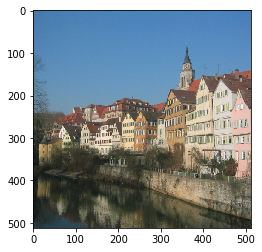

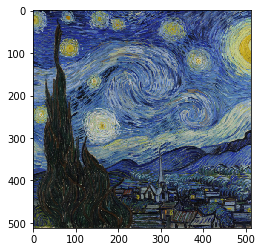

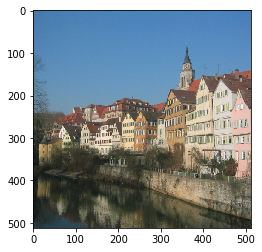

In [0]:
# Train

# content(a), style(p), image(x)를 정의
content = image_preprocess(content_dir).to(device) # [1 x 3 x 512 x 512]
style = image_preprocess(style_dir).to(device) # [1 x 3 x 512 x 512]

# input image(x)는 white noise 대신 content를 사용함.
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad, style.requires_grad, generated.requires_grad)

# 시각화
plt.imshow(image_postprocess(content[0].cpu())) # CUDA tensor는 numpy로 변환이 안되기에 cpu로 바꾸어줌.
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

이제 `style_target`과 `content_target`을 정의하겠습니다. Style은 cnn의 각 layer의 결과물을, content는 특정 layer의 결과물로 정의합니다. 근데 여기서 보면 style의 합이 1이 되지 않는 것을 볼 수 있습니다. 이 또한 원 논문과 다른점입니다.

In [0]:
# Set targets & style weights

# style은 network의 각 layer 결과물의 Gram matrix 결과값 ($A^l$)
style_target = list(gram_matrix(i) for i in resnet(style)) # i는 output_0, 1, ... (i.e. feature map)
# 만일 GramMSELoss 내에서 Gram amtrix를 계산한다면 다음과 같이 사용:
# style_target = list(i for i in resnet(style))


# content는 특정 레이어 하나에서만 뽑아내게 됨.
# 우리는 content_layer_num에서 뽑아내기로 결정하였으므로, 여기서 뽑아냄.
content_target = resnet(content)[content_layer_num]

# style loss에서 각 layer별로 가져올 가중치.
# Q. 근데 특정 몇몇만 가져오고 나머지는 0에 가깝게 처리한다 했는데?
# Q. 심지어 summation이 1이 안됨.
style_weight = [1/n**2 for n in [64, 64, 256, 512, 1024, 2048]]

In [0]:
# style이 어떻게 생겼는지 살펴보자
print(f"# of styles:{len(style_target)}")

for style in style_target:
    print(style.size())

# of styles:6
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 1024, 1024])
torch.Size([1, 2048, 2048])


원래 style (Gram matrix 결과)은 다음과 같은 차원이 나온다
```
# of styles:6
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 2048, 16, 16])
```

In [0]:
# content도 확인.
print(f"contents:")
for i, value in enumerate(resnet(content)):
    if i == 1:
        print("**밑에가 바로 content layer**")
    print(value.size())

contents:
torch.Size([1, 64, 256, 256])
**밑에가 바로 content layer**
torch.Size([1, 64, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 2048, 16, 16])


우리는 L-BFGS를 optimizer로 사용할 것입니다. 그러나 

loss값을 sum하는 이유도 불분명합니다. content/style loss의 dimension을 살펴보면, 
```python
content_loss = nn.MSELoss().to(device)(out[content_layer_num], content_target)
content_loss.size(), torch.sum(content_loss).size()

(torch.Size([]), torch.Size([]))
```  
즉, 둘다 scalar임을 확인할 수 있습니다.

이제 학습을 할 차례입니다. LBFGS에 입력될 것은 우리의 input image $x$이므로, 이를 list 형태로 전달해 줍니다.

Optimization step, 즉 gradient를 업데이트 할 때는 두 가지 방법으로 할 수 있습니다.

첫 번째는 우리가 자주쓰는 `optimizer.step()`으로, 대부분의 optimizer에서 지원하는 간략화된 버전입니다.  

 두번째 방법은 `optimizer.step(closure)`입니다. Conjugate Gradient나 LBFGS와 같은 특정 최적화 알고리즘은 `step` 함수를 여러번 재평가해야합니다. 이를 위해 clsoure를 전달하여 알고리즘이 우리의 모델을 재연산(recompute)하도록 해야합니다. closure함수는 gradient를 초기화하고, loss를 계산하며, 이를 반환해야합니다:
```python
for input, target in dataset:
    def closure():
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss
    optimizer.step(closure)
```

In [0]:
# Train

# LBFGS를 optimizer로 사용함
optimizer = optim.LBFGS([generated]) # models.parameters()를 넣듯, 우리의 학습 대상인 generated를 넣는 것임.

iteration = [0] # closure를 사용하기 때문에 call by reference를 사용하기 위함임
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated) # 6개의 noise image x

        # style loss는 각 layer의 feature map (out[i])과 이의 gram matrix를 섞은 것.
        # channel의 output이 제각각이므로, tensor로 묶어줄 수 없음.
        style_loss = [GramMSELoss().to(device)(out[i], style_target[i]) * style_weight[i] for i in range(len(style_target))]

        # content loss는 content_layer_num에서만 가져옴.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num], content_target)
        
        # 말했듯 \frac{\alpha}}\beta = 10^{-3}이 되도록 설정함.
        # style_loss는 list이기에 sum을, content_loss는 scalar이기에 torch.sum 생략.
        total_loss = 1000 * sum(style_loss) + content_loss
        # Q. generated 가 Parameter가 아닌데 왜 gradient가 흐르지?
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss
    
    optimizer.step(closure)

tensor(545.8798, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.6208, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2843, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1888, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1695, device='cuda:0', grad_fn=<AddB

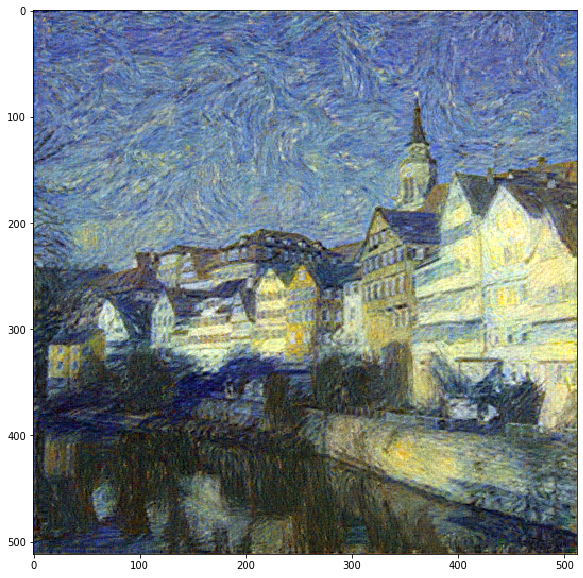

In [0]:
# 학습된 결과 이미지를 확인합니다.

gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()

## Experiment

### PyTorch Tutorial 따라하기
직접 구현할려던 차에 [pytorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)에서 이를 다루고 있기 때문에, 이를 번역하는 방식으로 해보겠습니다. 지금까지 위 책 코드 예제에서 논문과 다른점은 다음과 같습니다.
- VGG19
 - 16개의 Conv layer와 5개의 pooling 사용.
 - 네트워크 정규화를 해줌.
 - Maxpool 대신 avgpool 사용.
- Content 는 conv4 layer에서 가져옴.
- Style loss를 계산할 때 각 레이어에 대한 가중치의 합이 1이며, 가중치는 0이 아니면 모두 같음: $\sum w_l=1, \: w_i=w_j\textrm{ if } w_i \neq 0 \textrm{ else } w_i=0$
- 학습할 이미지 $x$는 noise image로 세팅

In [0]:
# 필요한 이미지들을 다운받습니다.

!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/content")
  os.mkdir("images/style")
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

rm: cannot remove 'images': No such file or directory
--2019-12-20 11:04:12--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘images/content/Tuebingen_Neckarfront.jpg’

Tuebingen_Neckarfro 100%[===================>] 397.00K  --.-KB/s    in 0.03s   

2019-12-20 11:04:12 (15.2 MB/s) - ‘images/content/Tuebingen_Neckarfront.jpg’ saved [406531/406531]

--2019-12-20 11:04:16--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import copy

# load and display images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [0]:
image_size = 512 if torch.cuda.is_available() else 128 # gpu사용 불가면 작은 사이즈를 이용
epoch = 5000

content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

원본 PIL은 0에서 255사이의 값을 갖으나, torch tensor형태로 변형할 경우 0과 1 사이 값을 갖도록 변환됩니다. 또한, 이미지들은 모두 갖은 사이즈를 갖도록 resize됩니다. 한 가지 짚고 넘어갈 중요한 점은 torch library의 neural network는 0과 1사이의 값을 갖는 tensor로 훈련된다는 점입니다. 만약 0-255의 tensor image로 훈련을 할 경우 content와 style을 feature map으로부터 감지할 수 없게됩니다.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose([
                             transforms.Resize(image_size),
                             transforms.CenterCrop(image_size), # 이게 없으니 width만 512가 되어서 추가하였음.
                             transforms.ToTensor()
])

def image_loader(img_dir):
    image = Image.open(img_dir)
    # input이 batch로 받기 때문에 이를 위해 가짜 batch dimension을 만들어줍니다.
    image = loader(image).unsqueeze(0)
    return image.to(device)

style_img = image_loader(style_dir)
content_img = image_loader(content_dir)

print(style_img.size(), content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


이제 이미지를 복사하여 다시 PIL 이미지로 재변환하는 함수를 만들어 보겠습니다. `plt.imshow`를 이용하여 이미지를 display합니다.

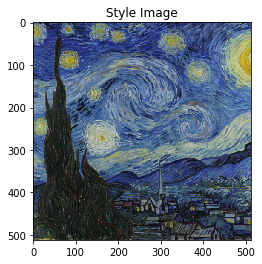

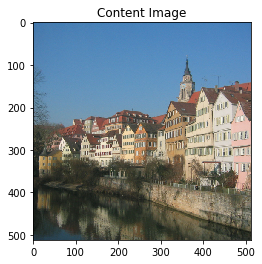

In [0]:
# transforms.ToPIImage()
# Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape H x W x C 
# to a PIL Image while preserving the value range.
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # 이전의 가짜 배치 차원을 삭제합니다.
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title="Content Image")

이제 content loss를 계산하겠습니다. 

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        # 파라미터 target은 gradient를 동적으로 계산하는 트리 (그래프)에서 '분리(detach)'됨.
        # : 이는 명시된 값 (stated value)으로, 변수(variable)가 아님.
        # 그렇지 않으면 criterion의 forward 메소드가 에러를 발생시킬 것임.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

주의할 점은 비록 이름에 'loss'가 들어갔을지라도, 이는 진정한 pytorch loss 함수는 아닙니다. 만일 loss function을 구현하고 싶다면, `backward` 메소드에서 그레디언트를 직접 계산하는 PyTorch autograd 함수를 만들어야합니다.

다음은 style loss의 계산입니다. 여기서는 batch 차원이 없는 것이 보입니다.

Gram matrix는 반드시 matrix의 원소 개수로 나누어 normalizing해야 합니다. 이는 feature map의 사이즈가 큰 경우 gram matrix가 큰 값을 갖을 수 있기 때문입니다.

논문과 다른 부분은 channel의 평균으로 gram matrix를 계산하지 않는다는 점입니다.

In [0]:
def gram_matrix(input):
    b, c, w, h = input.size() # [b, c, w, h]
    features = input.view(b * c, w * h) # Q. batch size는 어디로?
    G = torch.mm(features, features.t())

    # Gram matrix의 값을 각 feature map에 있는 원소의 개수로 나눔.
    return G.div(b * c * w * h)

In [0]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

이제 모델을 불러올 시간입니다. PyTorch의 VGG 구현은 두 개의 `Sequential` child module이 있습니다. 이는 `features`(convolution과 pooling)과 `classifier`(FC)입니다. 우리는 content loss와 style loss를 계산하기 위해 매 convolution의 결과물이 필요하니 features만 쓰겠습니다. 몇몇 레어이는 train과 inference시 동작이 다르므로 `eval()`모드로 사용하겠습니다.

In [0]:
# 논문과 마찬가지로 여기서는 VGG19를 사용하겠음.
vgg = models.vgg19(pretrained=True).features.to(device).eval()

VGG는 이미지의 각 채널이 normalize 되어있으므로, 책 코드 예제에서 해줬던 것과 같이 normalize 해주어야 합니다.

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 추후에 nn.Sequential에 쉽게 넣을 수 있도록 module로 만듭니다.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # mean과 std에 대해 .view를 이용하여 [C x 1 x 1]과 같은 꼴로 만들어줍니다.
        # 이는 [B x C x H x W]로 된 이미지 텐서에 곧바로 적용하기 위함입니다.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Network를 구성하기 앞서 VGG19의 모습을 다시 한번 살펴봅시다.

<center>
<img src="https://www.popit.kr/wp-content/uploads/2018/04/vgg-19.png" weight="500" height="400">
</center>

In [0]:
for name, model in vgg.named_children():
    print(name, model)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)


`Sequential` 모듈은 child module의 ordered list를 갖고 있습니다. 우리의 content loss와 style loss를 convolution layer 바로 다음에 추가해보겠습니다. 이를 위해서는 새로운 `Sequential` 모듈을 만들고 이 안에 loss들을 올바르게 넣어주면 됩니다.

이 부분도 원 논문과는 차이가 있습니다. avgpooling을 사용하지 않았습니다. 또한, 블록을 conv_1으로 취급하는 것이 아닌, 매 conv layer를 하나의 블록으로 처리하는 것 처럼 보입니다.

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    # 모듈을 갖고 오는 방법도 있지만, 여기서는 copy를 사용.
    cnn = copy.deepcopy(cnn)

    # Normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # list로 만들어 순차적 접근을 할 수 있게끔 만듬.
    content_losses = []
    style_losses = []

    # Sequential을 새롭게 만들고, 이에 전처리 및 로스들을 담겠음.
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        # isinstance로 layer를 구분하는건 많이 본 패턴임.
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            # in-place 형태는 우리의 content/style loss와 잘 작동하지 않으므로 replace하지 않는 버전을 사용.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # content layer는 4에서 뽑기로 함.
            # contnet loss 추가
            target = model(content_img).detach()    # Q. 굳이 detach 하는 이유가?
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # style loss 추가
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 이제 마지막 content/style layer 이후는 다 잘라냅니다.
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
        
    model = model[:(i+1)]

    return model, style_losses, content_losses

conv_4에서 model(style_img)가 아무것도 반환하지 않는 현상을 발견. 직접 테스트해보자.

In [0]:
model = nn.Sequential(Normalization(cnn_normalization_mean, cnn_normalization_std))
for i, layer in enumerate(vgg.children()):
    print(layer)
    model.add_module(str(i), layer)
    print(model)
    model(style_img)
    print("="*100)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ReLU(inplace=True)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ReLU(inplace=True)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


이제 input image를 고르면 됩니다. input image는 content image나 white noise를 사용합니다.

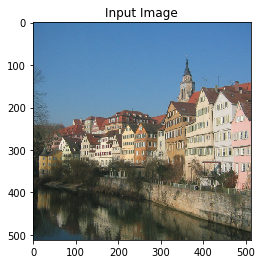

In [0]:
input_img = content_img.clone()
# white noise의 경우 아래와 같이 사용:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

이제는 gradient descent를 사용하면 됩니다. 모두가 다 알듯 L-BFGS를 사용할 것입니다.

In [0]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

마지막으로 neural transfer 작동을 구현해야 합니다. 네트워크의 각 iteration에서, update된 input_img를 토대로 loss를 계산할 것입니다. 우리는 각 loss 모듈의 `backward` 메소드를 실행시켜 이들의 gradient를 dynamic하게 계산할 것입니다. 우리의 L-BFGS optimizer는 closure를 필요로 하는데, 이는 모듈을 재평가하고, loss를 내놓습니다.

한 가지 제약조건이 더 남았습니다. 우리의 네트워크는 범위가 0-1를 넘는 input image에 대해 최적화 하려고 시도할 수도 있습니다. 이는 네트워크의 동작동안 input image가 0-1의 범위를 갖도록 고쳐주어 해결할 수 있습니다.

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1): # 값이 좀 과한데?
                       
    """Run the style transfer"""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 0-1값 보장
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss # Q. 모듈에 loss라는 attr이 있나?
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Optimizing..
run [50]:
Style Loss : 98.286736 Content Loss: 32.439014

run [100]:
Style Loss : 35.434742 Content Loss: 28.924355

run [150]:
Style Loss : 15.016772 Content Loss: 23.842964

run [200]:
Style Loss : 7.261769 Content Loss: 19.845577

run [250]:
Style Loss : 4.880673 Content Loss: 16.783310

run [300]:
Style Loss : 3.708337 Content Loss: 14.896526



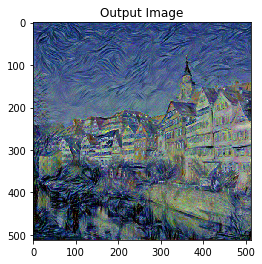

In [0]:
output = run_style_transfer(vgg, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()